Saving archive (3).zip to archive (3) (1).zip
Dataset Loaded Successfully!

                             Patient_ID  Age     Sex Family_History  \
0  b2a49170-8561-4665-9371-2240b55dd87a   31    Male             No   
1  f5fae45d-8718-41c4-a957-6928f79f3c8e   33  Female            Yes   
2  66ab0567-050b-4d56-9ec4-b676309899a6   69    Male            Yes   
3  996a48e4-e841-418f-a539-5a7a86cd815d   66    Male            Yes   
4  d45c7ca8-7125-4aaa-8018-5bbc60d35a1f   43  Female            Yes   

   HTT_CAG_Repeat_Length Motor_Symptoms Cognitive_Decline  Chorea_Score  \
0                     67       Moderate            Severe          8.80   
1                     38         Severe          Moderate          3.24   
2                     37         Severe          Moderate          1.01   
3                     50           Mild            Severe          3.21   
4                     48       Moderate              Mild          2.31   

   Brain_Volume_Loss  Functional_Capacity  ...

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


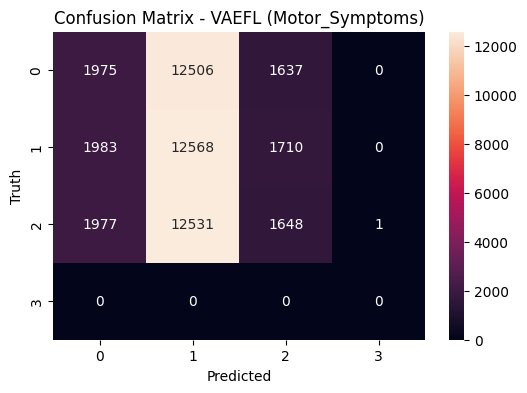


Training VAEFL for: Disease_Stage


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.2488
Precision: 0.2386
Recall: 0.2488
F1 Score: 0.1897


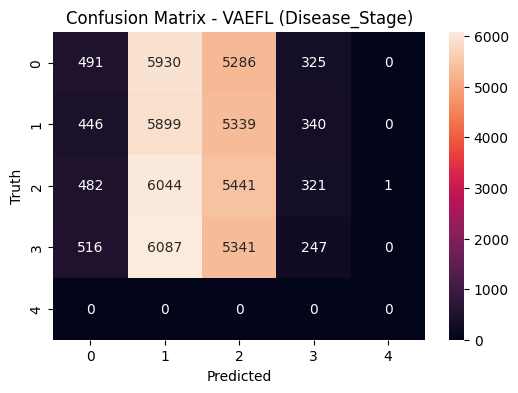


Training VAEFL for: Category
Accuracy: 0.2758
Precision: 0.3756
Recall: 0.2758
F1 Score: 0.2194


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


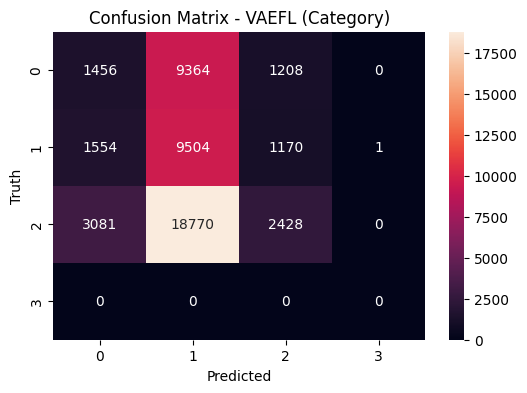


===== Comparison of Final Model Results =====
   Model          Target  Accuracy  Precision    Recall  F1 Score
0  VAEFL  Motor_Symptoms  0.333587   0.332308  0.333587  0.267691
1  VAEFL   Disease_Stage  0.248846   0.238566  0.248846  0.189664
2  VAEFL        Category  0.275836   0.375576  0.275836  0.219385

Per-Target Accuracy:
VAEFL - Motor_Symptoms: 33.36%
VAEFL - Disease_Stage: 24.88%
VAEFL - Category: 27.58%

Overall Dataset Accuracy (Average of all targets):
VAEFL: 28.61%


In [2]:
# libraries
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# upload and load dataset
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/")

extracted_files = os.listdir("/content/")
csv_file = [f for f in extracted_files if f.endswith(".csv")][0]
csv_path = os.path.join("/content/", csv_file)

df = pd.read_csv(csv_path)
print("Dataset Loaded Successfully!\n")
print(df.head(), "\n")
print("Dataset Info:\n")
print(df.info(), "\n")

# cleaning
df = df.ffill()
print("\nMissing values after cleaning:\n")
print(df.isnull().sum())

# drop high-leakage columns
df = df.drop(columns=[
    "Patient_ID",
    "Function",
    "Effect",
    "Gene/Factor",
    "Chromosome_Location",
    "Random_Protein_Sequence",
    "Random_Gene_Sequence"
], errors='ignore')

# label encoding
label_encoders = {}
for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nMotor_Symptoms Categories Count:")
print(df["Motor_Symptoms"].value_counts())
print("\nDisease_Stage Categories Count:")
print(df["Disease_Stage"].value_counts())
print("\nCategory (Final Diagnosis) Count:")
print(df["Category"].value_counts())

# prepare features
X = df.drop(columns=["Motor_Symptoms","Disease_Stage","Category"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

results = []

# define simple VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# model function
def run_vae(target):
    print("\n========================================")
    print(f"Training VAEFL for: {target}")
    print("========================================")

    y = df[target].values
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    input_dim = X_tensor.shape[1]
    model = VAE(input_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # training loop (small epochs for demo)
    model.train()
    for epoch in range(20):
        for xb, _ in loader:
            optimizer.zero_grad()
            xb_recon, mu, logvar = model(xb)
            loss_recon = criterion(xb_recon, xb)
            loss = loss_recon
            loss.backward()
            optimizer.step()

    # predict (using nearest class by comparing reconstructed feature sums)
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(X_tensor)
        pred_sums = recon.sum(dim=1).numpy()
        bins = np.linspace(pred_sums.min(), pred_sums.max(), len(np.unique(y))+1)
        y_pred = np.digitize(pred_sums, bins)-1

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - VAEFL ({target})")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

    results.append(["VAEFL", target, acc, prec, rec, f1])

# run VAEFL model
run_vae("Motor_Symptoms")
run_vae("Disease_Stage")
run_vae("Category")

# final results
results_df = pd.DataFrame(results, columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n===== Comparison of Final Model Results =====")
print(results_df)

# per target accuracy
print("\nPer-Target Accuracy:")
for index, row in results_df.iterrows():
    print(f"{row['Model']} - {row['Target']}: {row['Accuracy']*100:.2f}%")

# overall accuracy
print("\nOverall Dataset Accuracy (Average of all targets):")
overall_acc_dict = {}
for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    overall_dataset_acc = subset["Accuracy"].mean()
    overall_acc_dict[model] = overall_dataset_acc
    print(f"{model}: {overall_dataset_acc*100:.2f}%")
